# Example: Kernel-based Dynamics

- Author: Dr. Daning Huang
- Date: 09/27/2025
- Edit: 10/14/2025

## Introduction

The kernel model, esp. kernel ridge regression (KRR), is a popular type of linear models for regression with nonlinear features.

### Scalar case

Given a dataset of $N$ samples, inputs $X=[x_1,x_2,\cdots,x_N]$ and outputs $Y=[y_1,y_2,\cdots,y_N]$, the KRR model is
$$
y = k(x,X)\theta,\quad \theta\in\mathbb{R}^N
$$
where $k$ is a positive definite kernel function - such that $k(X,X)$ is a positive definite matrix for any $X$.  One example is Gaussian kernel $k(x,x';l)=\exp(-\|x-x'\|^2/(2l^2))$, with a learnable length scale $l$.  The coefficients $\theta$ are learned in closed form
$$
\theta = (k(X,X)+\lambda I)^{-1}Y
$$
where $\lambda$ is a ridge parameter for regularization.

### Vector case

For the case of multiple outputs, one could fit

- `MultiOuputShared`: one KRR for each output, and each KRR share the same kernel function
- `MultiOuputIndep`: one KRR for each output, and each KRR has a different kernel function
- `OperatorValued`: Using a *matrix* kernel function, one fit one large KRR for all output

For the last case, one simple example is the separable kernel,
$$
K(x,x') = \sum_{i=1}^M k_i(x,x')B_i
$$
where $k_i$ is a scalar kernel, such as Gaussian, and $B_i$ is a coefficient matrix.

Another special case is the diagonal kernel
$$
K(x,x') = \mathrm{diag}[k_1(x,x'),\cdots, k_M(x,x')]
$$
which is the same as `MultiOuputIndep`.

### Applying to dynamics

The KRR can provide a parametrized model $f(z;\Theta)=K(z,Z)\Theta$, and it can be used to represent the dynamics.  Some typical forms are

- `ContinuousTime`: $\dot{z}=f(z;\Theta)$
- `DiscreteTime`: $z_{n+1}=f(z_n;\Theta)$
- `SkipConnection`: $z_{n+1}=z_n + f(z_n;\Theta)$

Furthermore, one can wrap around the dynamics with an autoencoder that maps observations $x$ and inputs $u$ to latent states $z$.

To learn the dynamics, one can either

- Estimate $\dot{z}$ or use $z_{n+1}$ to assemble the targets for KRR, and use the closed form solution to find $\Theta$, or
- Pair the linear solution with our `NODETrainer` or `WeakFormTrainer` for further tuning (esp. when an autoencoder is used).

### In this example...

The philosophy of DyMAD is to modularize every piece, so that it can support as many combinations as possible.

For the case of kernels, it supports all possible combinations of the above, e.g., a `MultiOuputShared` kernel with `DiscreteTime` dynamics.  But with the same dynamics one can swap out to use a `OperatorValued` kernel, or with the same kernel swap out to use `SkipConnection` dynamics.  Lastly, any of these dynamics can be trained using our `LinearTrainer`, or further fine-tuned by other trainers.

We will demonstrate the above capabilities using a 2D dynamics that resides on a circle-like manifold.

## Setting up the Problem

The example is based on our work in [ICLR 2025](https://openreview.net/pdf?id=OwpLQrpdwE).

Consider an angular dynamics for $\theta$ periodic on $[0, 2\pi]$
$$
\dot{\theta} = 3/2 - \cos(\theta)
$$
we embed this dynamics in 2D with
$$
x = r\cos(\theta),\quad y=r\sin(\theta),\quad r=1+D\cos(K\theta)
$$
The embedding produces a manifold - a distorted circle, and larger $D$ gives larger distortion.

The main challenge to learn such dynamics is to keep the states on the manifold over a long time horizon.

In [1]:
import copy
import logging
import matplotlib.pyplot as plt
import numpy as np
import torch

from dymad.io import load_model
from dymad.models import DKM, DKMSK, KMM   # Some kernel models - explained later
from dymad.training import LinearTrainer   # Linear trainer for this example
from dymad.utils import plot_trajectory, setup_logging, TrajectorySampler

In [2]:
B = 1
N = 201
t_grid = np.linspace(0, 8, N)

s5 = np.sqrt(5)
K, D = 3, 0.3
# \dot{\theta} = 3/2 - \cos(\theta)
def dyn(tt, K=K, D=D):
    vv = 2 * np.arctan(np.tan(s5*tt/4)/s5)
    rr = 1 + D*np.cos(K*vv)
    uu = np.array([
        rr*np.cos(vv),
        rr*np.sin(vv)]).T
    return vv, uu
t_ref = np.linspace(0, 6, 51)
_ref = dyn(t_ref)[1]

def f(t, x):
    _x = np.atleast_2d(x)
    _t = np.arctan2(_x[:,1], _x[:,0])
    _v = 1.5 - np.cos(_t)
    _r = 1 + D*np.cos(K*_t)
    _d = -K*D*np.sin(K*_t)
    _c, _s = np.cos(_t)*_v, np.sin(_t)*_v
    _T = np.vstack([
        -_r*_s+_d*_c, _r*_c+_d*_s]).T
    return _T.squeeze()

In [ ]:
"""ker_data.yaml
dims:
  states: 2
  inputs: 0
  observations: 2

solver:
  method: RK45
  rtol: 1.0e-6
  atol: 1.0e-6
"""

In [4]:
smpl = {'x0': {
    'kind': 'perturb',
    'params': {'bounds': [0, 0], 'ref': _ref}}
    }  # Ensure the initial conditions are on manifold
sampler = TrajectorySampler(f, config='ker_data.yaml', config_mod=smpl)
ts, xs, ys = sampler.sample(t_grid, batch=B, save='./data/ker.npz')

Trajectory in phase space.

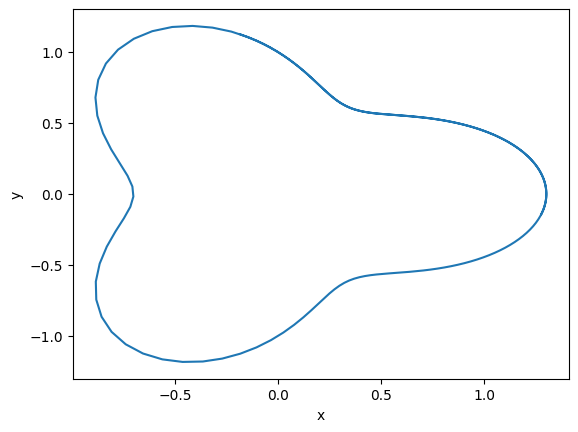

In [5]:
fig = plt.figure()
plt.plot(ys[0, :, 0], ys[0, :, 1])
plt.xlabel('x')
plt.ylabel('y');

Trajectory in time domain - quite oscillatory and non-trivial to learn.

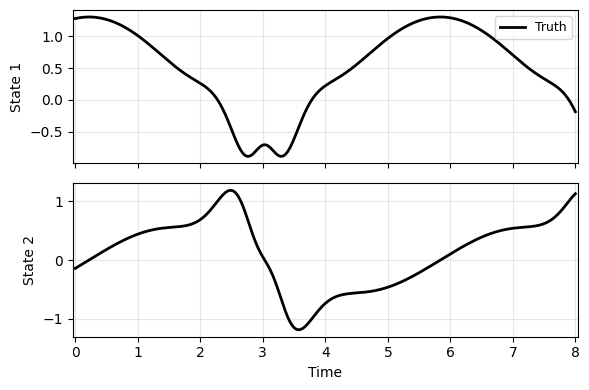

In [6]:
plot_trajectory(np.array([ys[0]]), ts[0], "S1", labels=['Truth'], ifclose=False)

## Setting up the Model

We will consider four models in this case.

- `dkm_exp`: `DiscreteTime` model with `MultiOuputShared` kernel, using an Exponential kernel $k(x,x';l)=\exp(-\|x-x'\|/l)$.
- `dks_exp`: `SkipConnection` model with `MultiOuputShared` kernel, using also an Exponential kernel.
- `dks_dm`: Same as #2 but using a Diffusion Map kernel.
- `kmm_tn`: `ContinuousTime` model with `OperatorValued` kernel, using a Tangent kernel from [ICLR 2025](https://openreview.net/pdf?id=OwpLQrpdwE).

### DiscreteTime, Exponential

In [7]:
# Dictionary for kernel
opt_exp = {
    "type": "sc_exp",           # Scalar, Exponential
    "input_dim": 2,             # Input dimension, the 2 states in our case
    "lengthscale_init": 1.0     # Prescribed length scale
}
# Dictionary for model
RIDGE = 1e-6                    # The ridge parameter
mdl_exp = {
    "name" : 'ker_model',
    "encoder_layers" : 0,
    "decoder_layers" : 0,
    "kernel_dimension" : 2,     # This is to match input_dim
    "type": "share",            # MultiOuputShared
    "kernel": opt_exp,          # Supply kernel here
    "dtype": torch.float64,
    "ridge_init": RIDGE
}

### SkipConnection, Exponential
This does not need additional definitions.  We just need to supply the previous dictionaries to a `SkipConnection` model.

### SkipConnection, Diffusion Map

In [8]:
opt_dm = {
    "type": "sc_dm",           # Scalar, Diffusion Map
    "input_dim": 2,
    "eps_init": None,          # If the length scale is not provided, a heuristic approach will be used
}
mdl_dm = copy.deepcopy(mdl_exp)
mdl_dm["kernel"] = opt_dm      # Only need to swap out the kernel

### ContinuousTime, OperatorValued

In [9]:
# Scalar kernel base - Gaussian
opt_rbf = {
    "type": "sc_rbf",
    "input_dim": 2,
    "lengthscale_init": 1.0
}
# Tangent kernel
opt_opk = {
    "type": "op_tan",
    "input_dim": 2,
    "output_dim": 2,
    "kopts": opt_rbf   # Builds upon a Gaussian kernel
}
# The model
mdl_mn = {
    "name" : 'ker_model',
    "encoder_layers" : 0,
    "decoder_layers" : 0,
    "kernel_dimension" : 2,
    "manifold" : {     # Options for manifold calculations
        "d" : 1,       # Intrinsic dimension
        "g" : 6,       # Order of Generalized Moving Least Squares
        "T" : 5        # Order of tangent basis estimation
    },
    "type": "tangent", # Specialized kernel model with tangent space
    "kernel": opt_opk,
    "dtype": torch.float64,
    "ridge_init": RIDGE
}

## Train the Model

### Training options

In [10]:
# Options for linear solution
trn_ln = {
    "n_epochs": 1,
    "save_interval": 100,
    "load_checkpoint": False,
    "ls_update": {
        "method": "raw",
        "interval": 500,
        "times": 1}
        }
# Options for the tangent model
# Using first-order finite difference for time derivative
trn_l1 = copy.deepcopy(trn_ln)
trn_l1["ls_update"].update({"kwargs": {"order": 1}})

config_path = 'ker_model.yaml'

# Collection of training configurations
cfgs = [
    ('dkm_exp', DKM,    {"model": mdl_exp, "training" : trn_ln}),
    ('dks_exp', DKMSK,  {"model": mdl_exp, "training" : trn_ln}),
    ('dks_dm',  DKMSK,  {"model": mdl_dm,  "training" : trn_ln}),
    ('kmm_tn',  KMM,    {"model": mdl_mn,  "training" : trn_l1}),
    ]
IDX = range(len(cfgs))
labels = [cfgs[i][0] for i in IDX]

In [ ]:
"""ker_model.yaml
data:
  path: './data/ker.npz'
  n_samples: 1
  n_steps: 201
  double_precision: true

transform_x:
  type: "identity"

transform_u:
  type: "identity"

split:
  train_frac: 1.0     # Only one trajectory, so no train-valid-test split

dataloader:
  batch_size: 1
"""

### The training

In [12]:
for i in IDX:
    mdl, MDL, opt = cfgs[i]
    opt["model"]["name"] = f"ker_{mdl}"
    setup_logging(config_path, mode='info', prefix='results')
    logging.info(f"Config: {config_path}")
    trainer = LinearTrainer(config_path, MDL, config_mod=opt)
    trainer.train()

## Prediction

We will focus on the long-term prediction capability.  The initial condition is randomly sampled from the manifold.

The first figure shows that all models tend to capture trend with the right wave form.

The second figure zooms, and shows that the scalar kernel models all show some lag in phase over time; meanwhile, the tangent kernel still follows the correct dynamics closely even after 22 cycles.

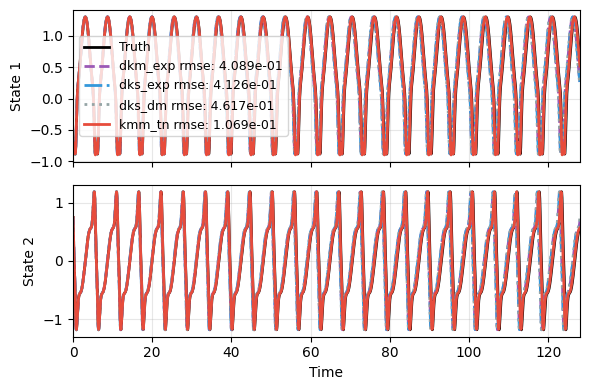

In [13]:
scl = 16
t_pred = np.linspace(0, 8*scl, N*scl)  # 16 times longer than training length
sampler = TrajectorySampler(f, config='ker_data.yaml', config_mod=smpl)
ts, xs, ys = sampler.sample(t_pred, batch=1)
x_data = xs[0]
t_data = ts[0]

res = [x_data]
for _i in IDX:
    mdl, MDL, _ = cfgs[_i]
    _, prd_func = load_model(MDL, f'ker_{mdl}.pt')
    with torch.no_grad():
        pred = prd_func(x_data, t_data)
    res.append(pred)

plot_trajectory(
    np.array(res), t_data, "S1",
    labels=['Truth']+labels, ifclose=False)

(110.0, 125.0)

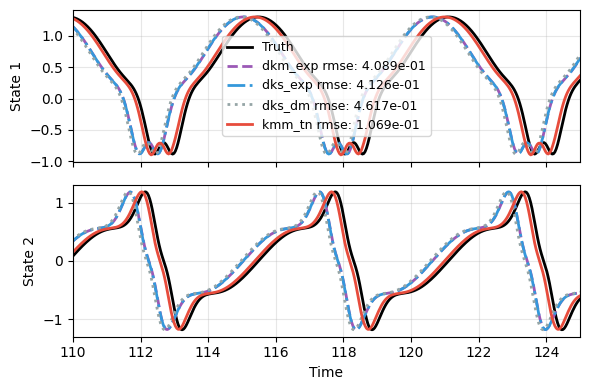

In [14]:
plot_trajectory(
    np.array(res), t_data, "S1",
    labels=['Truth']+labels, ifclose=False)
plt.xlim([110, 125])